   sepal_length  sepal_width  petal_length  petal_width target
0           5.1          3.5           1.4          0.2      0
1           4.9          3.0           1.4          0.2      0
2           4.7          3.2           1.3          0.2      0
3           4.6          3.1           1.5          0.2      0
4           5.0          3.6           1.4          0.2      0


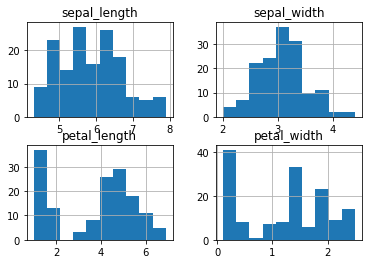

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
import matplotlib.pyplot as plt
%matplotlib inline

bunch = load_iris(as_frame=True)
bunch.frame.target = bunch.frame.target.astype('category')
frame = bunch.frame


frame.rename(columns=dict(zip(frame.columns,
                     ["sepal_length", "sepal_width", "petal_length", "petal_width", "target"])),
             inplace=True)
print (frame.head())

frame.hist()

train_data = frame.to_numpy()
names = frame.columns.tolist()
ptypes = [Gaussian for n in names[:-1]] + [Categorical]
categorical = [False]*(len(names))
categorical[-1] = True

In [8]:
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
from sklearn.model_selection import StratifiedKFold
import warnings

for n in range(5, 50+1, 5):
    splitter = StratifiedKFold()
    ll = []
    for train_i, test_i in splitter.split(train_data, train_data[:, -1]):
        train = train_data[train_i]
        test = train_data[test_i]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            np.random.seed(0)
            net = learn_parametric(train, 
                                   ds_context = Context(parametric_types=ptypes).add_domains(train), 
                                   min_instances_slice=n)
            l = log_likelihood(net, test)
            ll.append(-np.sum(l))
    print ("%6d %8.4f ± %8.4f" % (n, np.mean(ll), np.std(ll)))

     5 123.1225 ±  47.1550
    10  75.9083 ±  18.9892
    15  70.6761 ±  13.8833
    20  68.8639 ±  13.3471
    25  68.0280 ±  13.9266
    30  69.1821 ±  12.0539
    35  70.0713 ±  11.2689
    40  75.3368 ±  11.7656
    45  79.9439 ±  15.2862
    50  79.9439 ±  15.2862


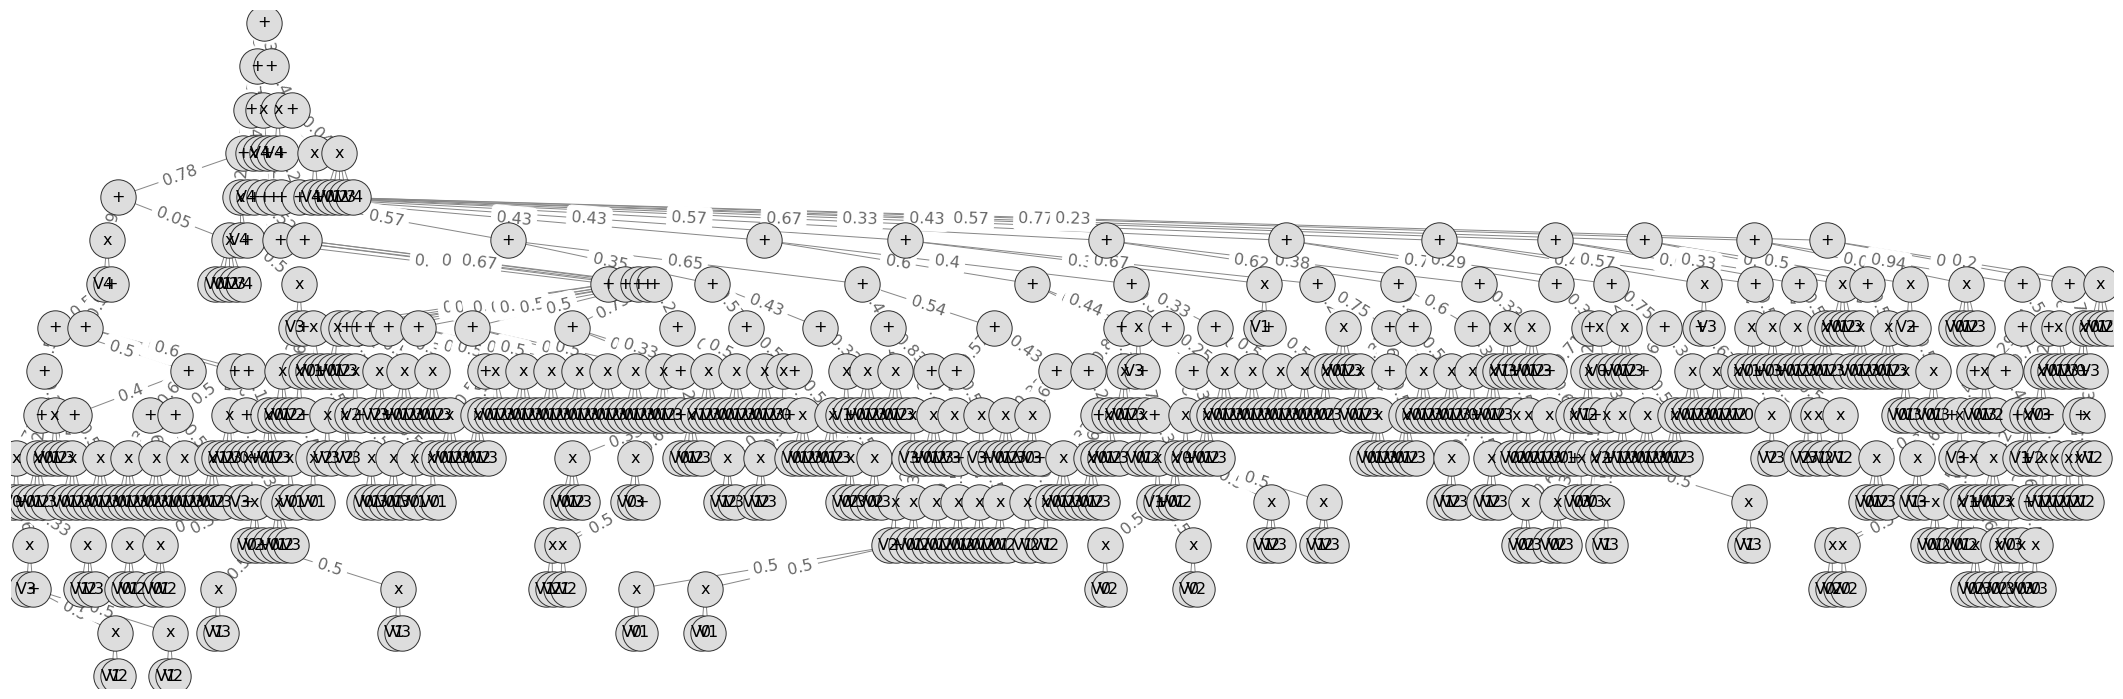

In [2]:
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
from spn.io.Graphics import plot_spn
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    net = learn_parametric(train_data, 
                           ds_context = Context(parametric_types=ptypes).add_domains(train_data), 
                           min_instances_slice = len(train_data)/100)

plt.figure(figsize=(30, 10))
plot_spn(net)

In [3]:
from csi import annotate, context_specific_independences

annotate(net, names, categorical, min_impurity_decrease=0.1, min_instances_slice=len(train_data)/20)
for rule in context_specific_independences(net):
    print (rule)

([['petal_length > 3.149999976158142'], ['target == 2']], [['target'], ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], 1.0, 49)
([['petal_length <= 3.149999976158142'], ['sepal_width > 3.25 and sepal_length > 4.8500001430511475']], [['target'], ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], 1.0, 28)
([['petal_length > 3.149999976158142'], ['target != 2'], ['sepal_length > 5.8500001430511475 and petal_length > 4.25']], [['target'], ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], 0.98, 23)
([['petal_length <= 3.149999976158142'], ['sepal_width <= 3.25', 'sepal_width > 3.25 and sepal_length <= 4.8500001430511475'], ['target != 1']], [['target'], ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], 0.9565217391304348, 22)
([['petal_length > 3.149999976158142'], ['target != 2'], ['sepal_length <= 5.8500001430511475', 'sepal_length > 5.8500001430511475 and petal_length <= 4.25'], ['petal_length > 3.850000023841858'], ['target ==

In [6]:
def format_clause(clause):
    parts = []
    for subclause in clause.split(" and "):
        # print (repr(subclause))
        try:
            a, sign, b = subclause.split(" ")
        except ValueError as e:
            print (e)
            return "NAN"
        # i = names.index(a)
        v = b #value_text[i][int(b)]
        if ('==' in sign) or ('!=' in sign):
            b = str(int(b))
            parts.append("(%s %s %s)" % (a, sign, b))
        else:
            b = float(b)
            parts.append("(%s %s %.4f)" % (a, sign, b))
    return " & ".join(parts)
def format_rule(rule):
    antecedent, consequent, score, support = rule
    
    anodes = [' | '.join(["(%s)"% format_clause(clause) for clause in node]) for node in antecedent]
    antecedent = ' & '.join([node if node.startswith("(") else "(%s)" % node for node in anodes])
    cnodes = ["(%s)" % ",".join(node) for node in consequent]
    consequent = ", ".join(cnodes)
    return antecedent, consequent, round(score, 4), min(support, len(D))
D = train_data
import csi
for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    print ("{%s} => {%s} (%.2f, %d)" % rule, end="\n\n")

{((petal_length > 3.1500)) & ((target == 2))} => {(target), (sepal_length,sepal_width,petal_length,petal_width)} (1.00, 49)

{((petal_length <= 3.1500)) & ((sepal_width > 3.2500) & (sepal_length > 4.8500))} => {(target), (sepal_length,sepal_width,petal_length,petal_width)} (1.00, 28)

{((petal_length > 3.1500)) & ((target != 2)) & ((sepal_length > 5.8500) & (petal_length > 4.2500))} => {(target), (sepal_length,sepal_width,petal_length,petal_width)} (0.98, 23)

{((petal_length <= 3.1500)) & ((sepal_width <= 3.2500)) | ((sepal_width > 3.2500) & (sepal_length <= 4.8500)) & ((target != 1))} => {(target), (sepal_length,sepal_width,petal_length,petal_width)} (0.96, 22)

{((petal_length > 3.1500)) & ((target != 2)) & ((sepal_length <= 5.8500)) | ((sepal_length > 5.8500) & (petal_length <= 4.2500)) & ((petal_length > 3.8500)) & ((target == 1))} => {(target), (sepal_length,sepal_width,petal_length,petal_width)} (0.93, 20)



In [12]:
subset = frame[(frame.petal_length <= 3.15) & (frame.sepal_width > 3.25) & (frame.sepal_length > 4.85)]
subset

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
7,5.0,3.4,1.5,0.2,0
10,5.4,3.7,1.5,0.2,0
14,5.8,4.0,1.2,0.2,0
15,5.7,4.4,1.5,0.4,0
16,5.4,3.9,1.3,0.4,0
17,5.1,3.5,1.4,0.3,0
18,5.7,3.8,1.7,0.3,0
